In [1]:
from pylab import plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')

In [2]:
V0 = 17.6639

In [3]:
r = 0.01

In [4]:
import pandas as pd
h5 = pd.HDFStore('./vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']  # VSTOXX futures data
options_data = h5['options_data']  # VSTOXX call option data
h5.close()

In [5]:
import datetime as dt

In [6]:
futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [7]:
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [8]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31 08:00:00,2014,4,17.85,2014-04-18 08:00:00,0.049
497,2014-03-31 08:00:00,2014,5,19.55,2014-05-16 08:00:00,0.126
498,2014-03-31 08:00:00,2014,6,19.95,2014-06-20 08:00:00,0.222
499,2014-03-31 08:00:00,2014,7,20.40,2014-07-18 08:00:00,0.299
500,2014-03-31 08:00:00,2014,8,20.70,2014-08-15 08:00:00,0.375
501,2014-03-31 08:00:00,2014,9,20.95,2014-09-19 08:00:00,0.471
502,2014-03-31 08:00:00,2014,10,21.05,2014-10-17 08:00:00,0.548
503,2014-03-31 08:00:00,2014,11,21.25,2014-11-21 08:00:00,0.644


In [9]:
options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [10]:
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [11]:
options_data['IMP_VOL'] = 0.0

In [12]:
from bsm_functions import *

In [13]:
tol = 0.5  # tolerance level for moneyness
for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values[0]
      # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']
                             < forward * (1 + tol)):
        # only for options with moneyness within tolerance
        imp_vol = bsm_call_imp_vol(
                V0,  # VSTOXX value 
                options_data.loc[option]['STRIKE'],
                options_data.loc[option]['TTM'],
                r,   # short rate
                options_data.loc[option]['PRICE'],
                sigma_est=2.,  # estimate for implied volatility
                it=100)
        options_data.ix[option, 'IMP_VOL'] = imp_vol

In [14]:
plot_data = options_data[options_data['IMP_VOL'] > 0]

In [15]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 08:00:00'),
 Timestamp('2014-05-16 08:00:00'),
 Timestamp('2014-06-20 08:00:00'),
 Timestamp('2014-07-18 08:00:00'),
 Timestamp('2014-08-15 08:00:00'),
 Timestamp('2014-09-19 08:00:00'),
 Timestamp('2014-10-17 08:00:00'),
 Timestamp('2014-11-21 08:00:00')]

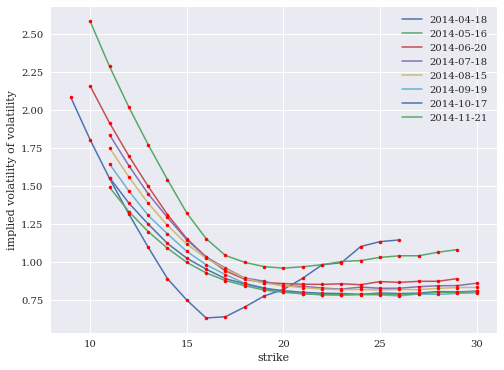

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
      # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'],
             label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='')
plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()

In [17]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

In [18]:
group_data = group_data.sum()
group_data.head()

PRICE   IMP_VOL
MATURITY            STRIKE                 
2014-04-18 08:00:00 9.0      8.85  2.083388
                    10.0     7.85  1.804193
                    11.0     6.85  1.550283
                    12.0     5.85  1.316103
                    13.0     4.85  1.097184

In [19]:
group_data.index.levels

FrozenList([[2014-04-18 08:00:00, 2014-05-16 08:00:00, 2014-06-20 08:00:00, 2014-07-18 08:00:00, 2014-08-15 08:00:00, 2014-09-19 08:00:00, 2014-10-17 08:00:00, 2014-11-21 08:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

In [20]:
from bsm_functions import bsm_call_value
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
bsm_call_value(S0, K, T, r, sigma)

8.0213522351431763

In [21]:
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

NameError: name 'S' is not defined

In [22]:
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

NameError: name 'S' is not defined

In [24]:
import numpy as np
import pandas as pd

In [27]:
raw = pd.read_csv('tr_eikon_eod_data.csv',
                   index_col=0, parse_dates=True)
AAPL = pd.DataFrame(raw['AAPL.O'])
AAPL.columns = ['Close']
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2010-01-04 to 2017-10-31
Data columns (total 1 columns):
Close    1972 non-null float64
dtypes: float64(1)
memory usage: 30.8 KB


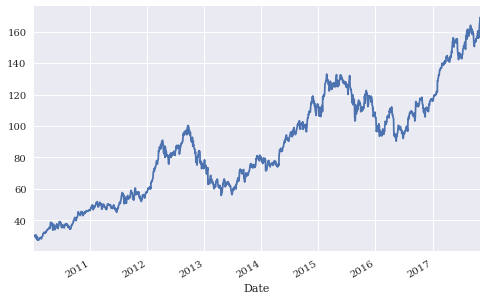

In [28]:
AAPL['Close'].plot(grid=True, figsize=(8, 5))


In [35]:
AAPL['42d'] = AAPL['Close'].rolling(window=42).mean()
AAPL['252d'] = AAPL['Close'].rolling(window=252).mean()
AAPL

,Close,42d,252d,42-252
Date,,,,
2010-01-04,30.572827,NaN,NaN,NaN
2010-01-05,30.625684,NaN,NaN,NaN
2010-01-06,30.138541,NaN,NaN,NaN
2010-01-07,30.082827,NaN,NaN,NaN
2010-01-08,30.282827,NaN,NaN,NaN
2010-01-11,30.015684,NaN,NaN,NaN
2010-01-12,29.674256,NaN,NaN,NaN
2010-01-13,30.092827,NaN,NaN,NaN
2010-01-14,29.918542,NaN,NaN,NaN


In [36]:
AAPL[['Close', '42d', '252d']].tail()

,Close,42d,252d
Date,,,
2017-10-25,156.41,157.610952,139.862520
2017-10-26,157.41,157.514286,140.028472
2017-10-27,163.05,157.517619,140.221210
2017-10-30,166.72,157.597857,140.431528
2017-10-31,169.04,157.717857,140.651766


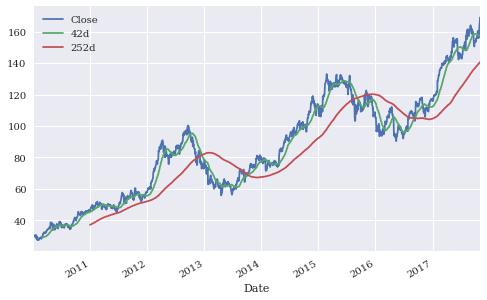

In [33]:
AAPL[['Close', '42d', '252d']].plot(grid=True, figsize=(8, 5))

In [34]:
AAPL['42-252'] = AAPL['42d'] - AAPL['252d']
AAPL['42-252'].tail()

Date
2017-10-25    17.75
2017-10-26    17.48
2017-10-27    17.30
2017-10-30    17.17
2017-10-31    17.07
Name: 42-252, dtype: float64

In [36]:
AAPL['42-252'].head()

Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
Name: 42-252, dtype: float64

In [37]:
AAPL.dropna(inplace=True)

In [39]:
AAPL['42-252'].head()

Date
2010-12-31    8.16
2011-01-03    8.16
2011-01-04    8.16
2011-01-05    8.15
2011-01-06    8.13
Name: 42-252, dtype: float64

In [40]:
SD = 0.5
AAPL['Position'] = np.where(AAPL['42-252'] > SD, 1, 0)
AAPL['Position'] = np.where(AAPL['42-252'] < -SD, -1, AAPL['Position'])
AAPL['Position'].value_counts()

 1    1260
-1     445
 0      16
Name: Position, dtype: int64

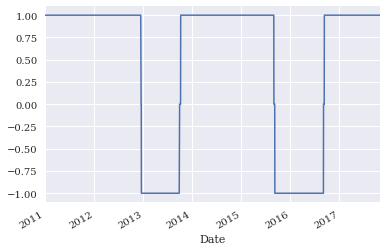

In [41]:
AAPL['Position'].plot(lw=1.5, grid=True)
plt.ylim([-1.1, 1.1]);

In [42]:
AAPL['Market'] = np.log(AAPL['Close'] / AAPL['Close'].shift(1))

In [43]:
AAPL['Strategy'] = AAPL['Position'].shift(1) * AAPL['Market']

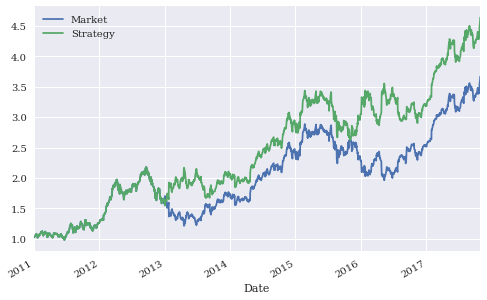

In [44]:
AAPL[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,
                                                    figsize=(8, 5));